<h1><font color="black">ECE 2195 Project: Texture Recognition using Touchpad and SNN</font></h1>

<h2><font color="black">Hardware and Initial Testing</font></h2>

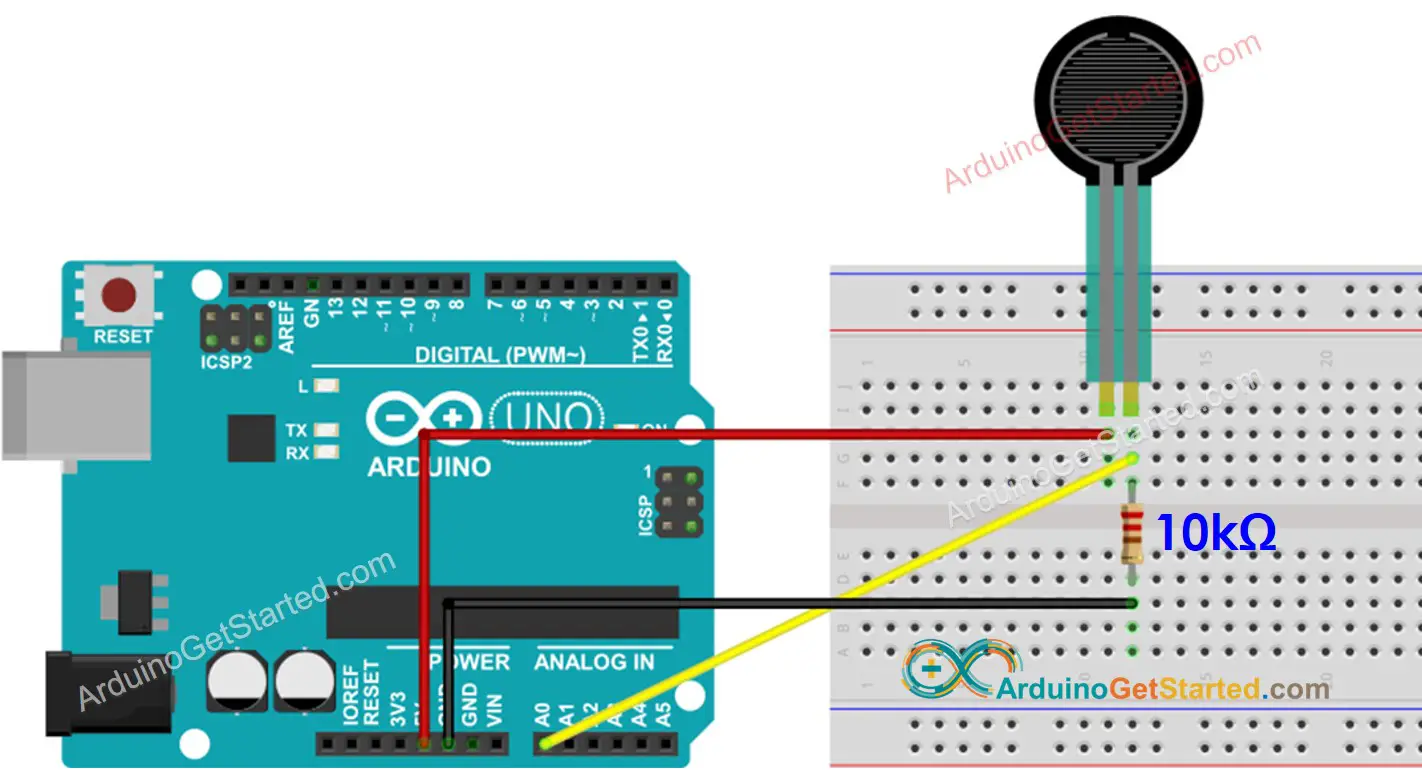

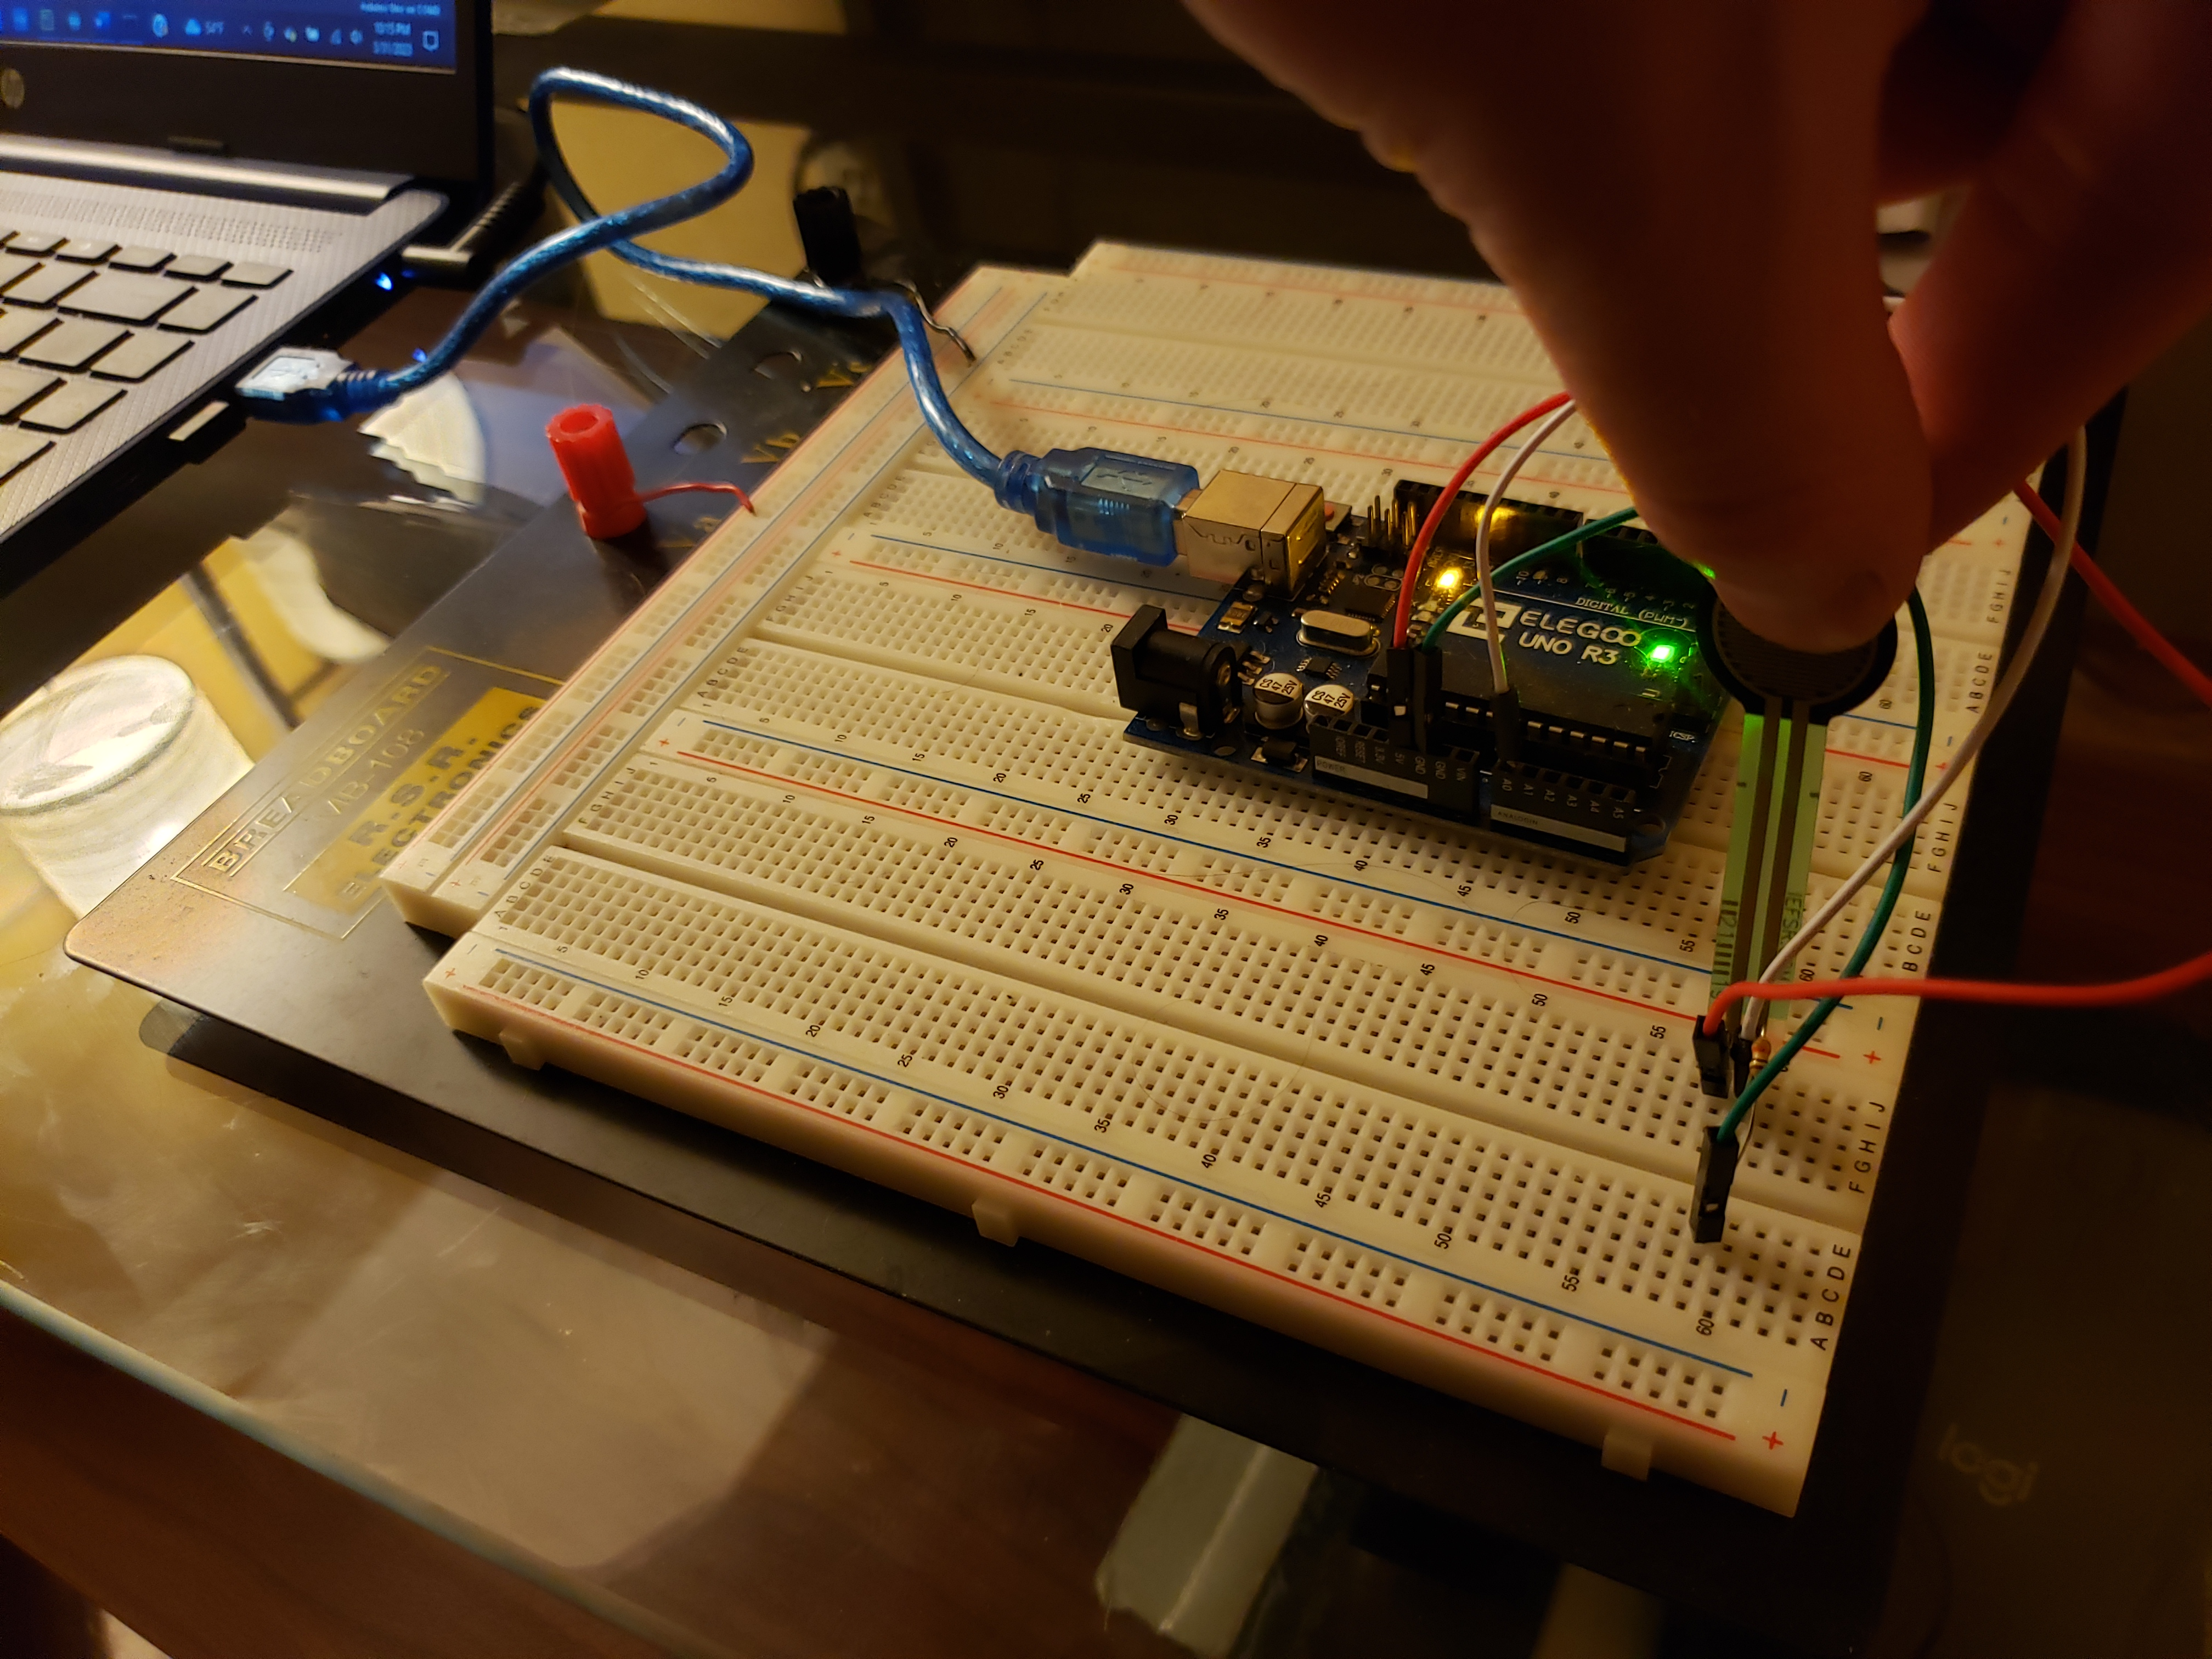

<h2><font color="black">Simple Data Monitoring Test</font></h2>

In [ ]:
import serial
import random

# try:
#     arduino = serial.Serial('COM3', '9600')
# except serial.SerialException:
#     print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')
    
rawdata = []
count = 0

while count < 1000:
    rawdata = random.randint(1, 22)
#     rawdata = float(arduino.readline())/50
    
    print("Force sensor reading = ")
    print(rawdata)

    if rawdata < 0.2:      
        print(" -> no pressure")
    elif rawdata < 2:
        print(" -> light touch")
    elif rawdata < 8:
        print(" -> light squeeze")
    elif rawdata < 14: 
        print(" -> medium squeeze")
    else: 
        print(" -> big squeeze")
        
    count += 1

<h2><font color="black">Ring Buffer Class</font></h2>

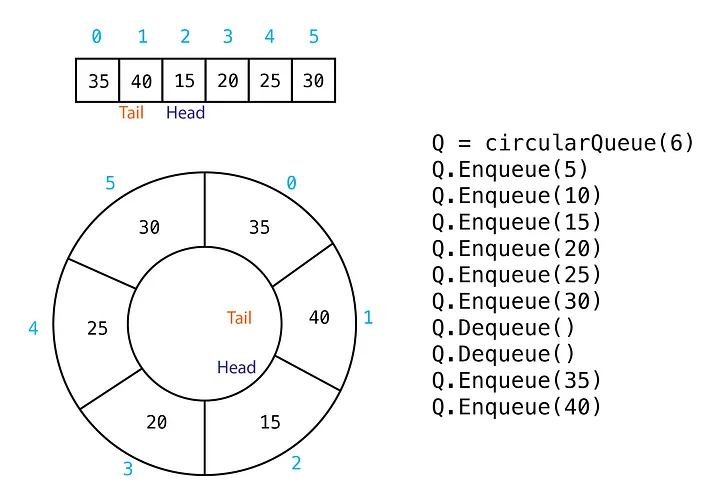

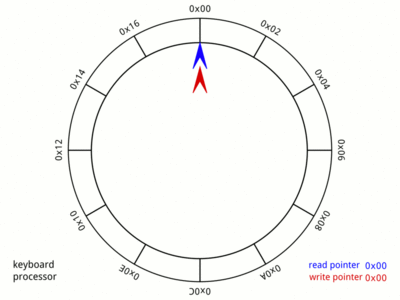

In [1]:
class RingBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.queue = [None] * capacity
        self.tail = -1
        self.head = 0
        self.size = 0

    '''
    Output useful variables
    '''
    def __str__(self):
        return f'Capacity: {self.capacity}\n Size: {self.size}\n Tail: {self.tail}\n Head: {self.head}'

    '''
    Add items to the ring buffer
    '''
    def enqueue(self, item):
        if self.size != self.capacity:
            self.tail = (self.tail + 1) % self.capacity
            self.queue[self.tail] = item
            self.size = self.size + 1
        else:
            print("Error: Ring Buffer is full!")

    '''
    Delete items from the ring buffer
    '''
    def dequeue(self):
        if self.size != -1:
            temp = self.queue[self.head]
            self.head = (self.head + 1) % self.capacity
            self.size = self.size - 1
            return temp
        else:
            print("Error: Ring Buffer is empty!")

    '''
    Get the item at the front of the ring buffer
    '''
    def front(self):
        return self.queue[0]

    '''
    Get the item at the end of the ring buffer
    '''
    def end(self):
        return self.queue[self.size-1]

    '''
    Get the current size of the ring buffer
    '''
    def size(self):
        return self.size

    '''
    Get the maximum size of the ring buffer
    '''
    def maxsize(self):
        return self.capacity

    '''
    Check if the ring buffer is full or not
    '''
    def full(self):
        if self.size == self.capacity:
            return True
        else:
            return False

    '''
    Check if the ring buffer is empty or not
    '''
    def empty(self):
        if self.size == 0:
            return True
        else:
            return False

    '''
    Get an item at a specified index
    '''
    def getitem(self, index):
        if index < self.size:
            return self.queue[index]
        else:
            print("Error: Index greater than ring buffer size!")

    '''
    Remove and return an item from the ring buffer
    '''
    def display(self):
        if self.size != 0:
            index = self.head
            for i in range(self.size):
                print(self.queue[index])
                index = (index + 1) % self.capacity
        else:
            print("Ring Buffer is empty!")

<h2><font color="black">Neuron Model Class</font></h2>

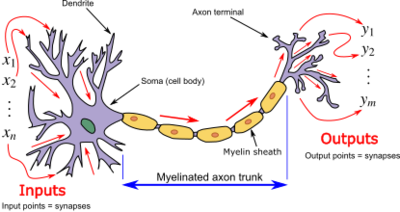

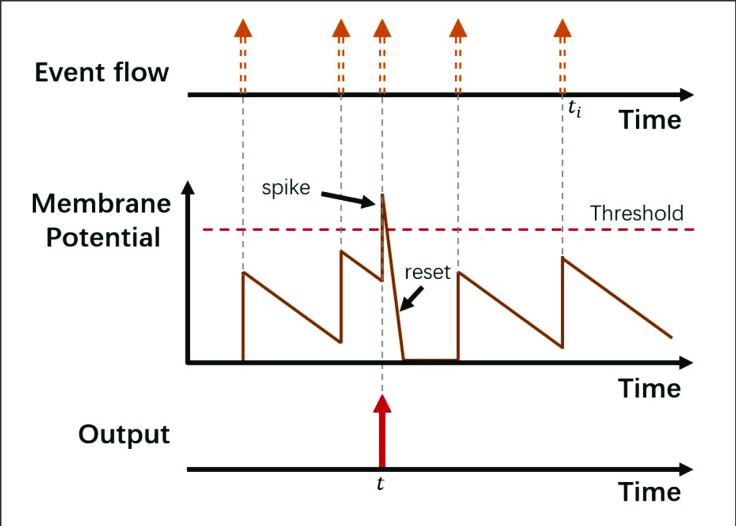

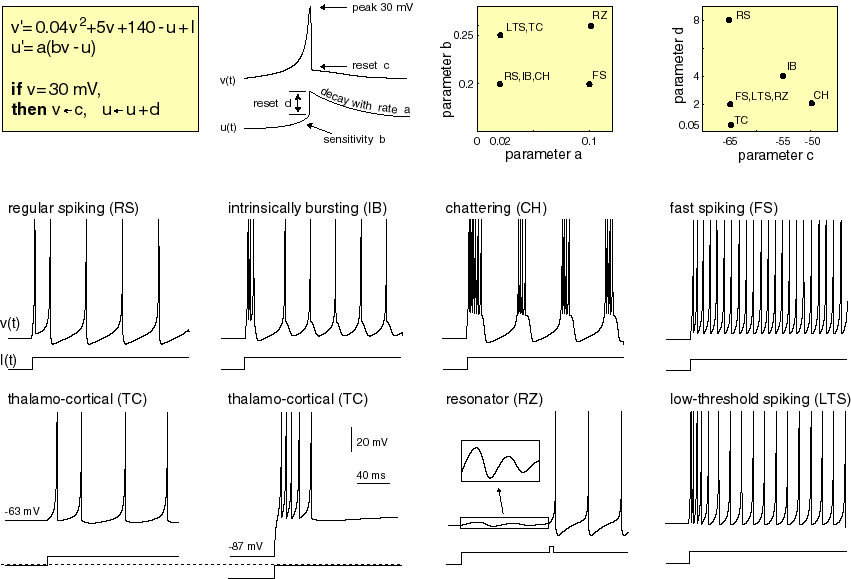

In [2]:
class NeuronModel:
    def __init__(self):
        pass

    def __str__(self):
        return 'This is the neuron model class. Current models include LIF and Izhikevich.'
    
    '''
    Function for LIF neuron model spiking behavior
    '''
    def run_spike_lif(self, v, vth, C_mem, I_inject, dt):
        event = 0
        # v is set to last (either reset or integrate)
        # Compare
        if v > vth:
            event = 50
            # Reset
            V_last = 0
        if v < vth:
            # Integrate
            V_last = ((I_inject * dt) / C_mem) + v
        return V_last, event
    
    '''
    Function for Izhikevich neuron model spiking behavior
    '''
    def run_spike_izhikevich(self, a, b, c, d, dt, v, u, bias, vth):
        event = 0
        dv = 0.04 * v ** 2 + 5 * v + 140 - u + bias  # dv/dt
        du = a * (b * v - u)  # du/dt
        v += dt * dv
        u += dt * du
        # If v = vth(mV), v is reset to c and u is reset to u + d
        if v >= vth:
            v = c
            u = u + d
            event = 30
        return v, u, event

<h2><font color="black">Characterization for LIF Neuron Model</font></h2>

In [ ]:
import serial 
import threading
import numpy as np
import matplotlib.pyplot as plt
import random


# Global objects to be used.
q = RingBuffer(1000)  # Instantiate ring buffer, pass in capacity.
arr = np.zeros(1000)  # Initialize an int array of zeros for a given size.

# Try to connect to Arduino, close Serial Monitor in Arduino IDE.
try:
    arduino = serial.Serial("COM3", baudrate=9600)
except serial.SerialException:
    print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')


# Get sensor data from Arduino in a separate flow of execution.
def get_data():
    count = 0
    # While the program persists, we get data.
    while count != 1:
        # Read in the serial data and divide by 50 for data usability.Sensor range is approximately 0.2N - 20 N
        rawdata = round(int(arduino.readline())/50) # Define pressure (N)
#         rawdata = random.randint(1, 20)
        # If the ring buffer is not full, fill. Otherwise, empty all.
        if not q.full():
            q.enqueue(rawdata)
        else:
            for i in range(q.capacity):
                arr[i] = q.dequeue()
            count += 1
                               
        
# The main flow of execution handles the neuron model while the program persists.
if __name__ == "__main__":
    # Call function to get data first.
    get_data()

     # Initialize all local variables for LIF and Izhikevich neuron models.
    # Initialize capacitance (uF)
    C_mem = 10e-7
    
    # Initialize current, this is pressure (uA)
#     I_inject = 0.1e-6
 
    # Initialize time-step and time.
    dt = 0.1
    time = np.arange(0, 100, dt)
    
    # Initialize voltages (V)
    V_last = 0
    V_mem =  np.zeros(time.shape[0] + 1)
    vth = 50  # Define threshold voltage.

    # Initialize arrays.
    v_array = np.zeros(time.shape[0])
    events = np.zeros(time.shape[0])
    pressure_event = np.zeros(time.shape[0])

    # Instantiate neuron model.
    nm = NeuronModel()
    
    # Do the work.
    for t in range(len(time)):
        V_last, event = nm.run_spike_lif(v=V_mem[t], vth=vth, C_mem=C_mem, I_inject=arr[t], dt=dt)
        v_array[t] = V_last
        events[t] = event
        V_mem[t+1] = V_last
        
        if event:
            pressure_event[t] = arr[t]
        else:
            pressure_event[t] = 0
    
    
    seen_event = set(pressure_event)
    duplicates = []
    unique = []

    for a in arr:
        if a in seen_event:
            duplicates.append(a)
    
    seen_duplicate = set(duplicates)
    
    for d in seen_duplicate:
        unique.append(d)
    
    print(f'Events happend at the corresponding pressures (N):\n {unique}')
    counts = np.zeros(len(unique))
    
    for i, n in enumerate(seen_duplicate):
        counts[i] = duplicates.count(n)
    
    print(f'\nEvents happend these amount of times for the corresponding pressures (N):\n {counts}')
    
    u = np.array(unique)
    
    # Find line of best fit
    a, b = np.polyfit(u, counts, 1)

    # Plot characterization curve for pressure versus event frequency.
    titles = ['Regular Spiking', 'Intrinsically Bursting', 'Chattering', 'Fast Spiking']
    plt.title(f'LIF {titles[0]} Characterization Curve')
    plt.xlabel('Pressure (N)')
    plt.ylabel('Event Frequency')
    plt.xlim([0, 20])
    
    # Add points to plot
    plt.scatter(u, counts)

    # Add line of best fit to plot
    plt.plot(u, a*u+b)

<h2><font color="black">Main Interface and Execution for LIF Neuron Model</font></h2>

In [ ]:
import serial 
import threading
import numpy as np
# Use "%matplotlib tk" for detatchted window
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Global objects to be used.
q = RingBuffer(1000)  # Instantiate ring buffer, pass in capacity.
arr = np.zeros(1000)  # Initialize an int array of zeros for a given size.

# Try to connect to Arduino, close Serial Monitor in Arduino IDE.
try:
    arduino = serial.Serial("COM3", baudrate=9600)
except serial.SerialException:
    print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')


# Get sensor data from Arduino in a separate flow of execution.
def get_data():
    # While the program persists, we get data.
    while True:
        # Read in the serial data and divide by 50 for data usability.Sensor range is approximately 0.2N - 20 N
        rawdata = round(int(arduino.readline())/50)*10**-6 # Define pressure (N)
        # If the ring buffer is not full, fill. Otherwise, empty all.
        if not q.full():
            q.enqueue(rawdata)
        else:
            for i in range(q.capacity):
                arr[i] = q.dequeue()
                               
        
# The main flow of execution handles the neuron model while the program persists.
if __name__ == "__main__":
    # Start thread to get pressure data and run as daemon so thread is killed when main function finishes.
    thread_x = threading.Thread(target=get_data, daemon=True)
    thread_x.start()

    # Initialize all local variables for LIF and Izhikevich neuron models.
    # Initialize capacitance (uF)
    C_mem = 10e-7
    
    # Initialize current, this is pressure (uA)
#     I_inject = 0.1e-6
 
    # Initialize time-step and time.
    dt = 0.1
    time = np.arange(0, 100, dt)
    
    # Initialize voltages (V)
    V_last = 0
    V_mem =  np.zeros(time.shape[0] + 1)
    vth = 50  # Define threshold voltage.

    # Initialize arrays.
    v_array = np.zeros(time.shape[0])
    events = np.zeros(time.shape[0])

    # Instantiate neuron model.
    nm = NeuronModel()
    # Create a figure with subplots.
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Initialize line objects (one in each axes).
    line1, = ax1.plot([], [], lw=3, color='b')
    line2, = ax2.plot([], [], lw=3, color='r')
    line = [line1, line2]

    # Initialize all axes, mark the x-axis and y-axis ranges and specify grid.
    for ax in [ax1, ax2]:
        ax.set_ylim(-5, 100)
        ax.set_xlim(0, 100)
        ax.grid()

    # Data which the line will contain (x, y).
    def init():
        line[0].set_data([], [])
        line[1].set_data([], [])
        return line

    # Animate our LIF neuron model spiking behavior.
    def animate(i):
        for t in range(len(time)):
            V_last, event = nm.run_spike_lif(v=V_mem[t], vth=vth, C_mem=C_mem, I_inject=arr[t], dt=dt)
            v_array[t] = V_last
            events[t] = event
            V_mem[t+1] = V_last
        
        # Update the data of our line objects.
        line[0].set_data(time, v_array)
        line[1].set_data(time, events)
        return line

    # Plot membrane potential (v) and recovery variable (u) for specified mode
    anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)
    titles = ['Regular Spiking', 'Intrinsically Bursting', 'Chattering', 'Fast Spiking']
    plt.suptitle(f'{titles[0]} for Membrane Potential (v) and Recovery Variable (u)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pressure (N)')
    ax.yaxis.set_label_coords(-0.1, 1.1)
    plt.show()


<h2><font color="black">Characterization for Izhikevich Neuron Model</font></h2>

In [ ]:
import serial 
import threading
import numpy as np
import matplotlib.pyplot as plt
import random


# Global objects to be used.
q = RingBuffer(1000)  # Instantiate ring buffer, pass in capacity.
arr = np.zeros(1000)  # Initialize an int array of zeros for a given size.

# Try to connect to Arduino, close Serial Monitor in Arduino IDE.
try:
    arduino = serial.Serial("COM3", baudrate=9600)
except serial.SerialException:
    print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')


# Get sensor data from Arduino in a separate flow of execution.
def get_data():
    count = 0
    # While the program persists, we get data.
    while count != 1:
        # Read in the serial data and divide by 50 for data usability.Sensor range is approximately 0.2N - 20 N
        rawdata = round(int(arduino.readline())/50) # Define pressure (N)
#         rawdata = random.randint(1, 20)
        # If the ring buffer is not full, fill. Otherwise, empty all.
        if not q.full():
            q.enqueue(rawdata)
        else:
            for i in range(q.capacity):
                arr[i] = q.dequeue()
            count += 1
                               
        
# The main flow of execution handles the neuron model while the program persists.
if __name__ == "__main__":
    # Call function to get data first.
    get_data()

    # Initialize all local variables for LIF and Izhikevich neuron models.
    a = 0.02  # Describes the timescale of the recovery variable u.
    b = 0.2  # Describes the sensitivity of u to the sub-threshold fluctuations of the membrane potential v.
    c = -65  # Describes the after-spike reset value of the membrane potential v caused by the caused by the fast high-threshold K+ conductances.
    d = 2  # Describes after-spike reset of u caused by slow high-threshold Na+ and K+ conductances.

    # Excitatory neurons.
    c_rs = -65  # Deep voltage reset for regular spiking.
    d_rs = 8  # Large after-jump spike of u for regular spiking.

    c_ib = -55  # High voltage reset for intrinsically bursting.
    d_ib = 4  # Large after-jump spike of u for intrinsically bursting.

    c_ch = -50  # Very high voltage reset for chattering.
    d_ch = 2  # Moderate after-jump spike of u for chattering.

    # Inhibitory neuron.
    a_fs = 0.1  # Fast recovery for fast spiking.

    # Initialize time-step and time.
    dt = 0.1
    time = np.arange(0, 100, dt)

    # Initialize arrays.
    v_array = np.zeros(time.shape[0])
    u_array = np.zeros(time.shape[0])
    events = np.zeros(time.shape[0])
    pressure_event = np.zeros(time.shape[0])

    # Create dictionary of variables for the modes of operation.
    modes = {
        'a': [a, a, a, a_fs],
        'b': [b, b, b, b],
        'c': [c_rs, c_ib, c_ch, c],
        'd': [d_rs, d_ib, d_ch, d]
    }

    # Instantiate neuron model.
    nm = NeuronModel()
    vth = 20  # Define threshold voltage.
    
    # Do the work.
    v = modes['a'][0]
    u = modes['b'][0] * v
    for t in range(len(time)):
        v, u, event = nm.run_spike_izhikevich(a=modes['a'][0], b=modes['b'][0], c=modes['c'][0], d=modes['d'][0],
                                       dt=dt, v=v, u=u, bias=arr[t], vth=vth)

        v_array[t] = v
        u_array[t] = u
        events[t] = event
        
        if event:
            pressure_event[t] = arr[t]
        else:
            pressure_event[t] = 0
    
    
    seen_event = set(pressure_event)
    duplicates = []
    unique = []

    for a in arr:
        if a in seen_event:
            duplicates.append(a)
    
    seen_duplicate = set(duplicates)
    
    for d in seen_duplicate:
        unique.append(d)
    print(f'Events happend at the corresponding pressures (N):\n {unique}')
    counts = np.zeros(len(unique))
    
    for i, n in enumerate(seen_duplicate):
        counts[i] = duplicates.count(n)
    
    print(f'Events happend these amount of times for the corresponding pressures (N):\n {counts}')
    
    u = np.array(unique)
    
    # Find line of best fit
    a, b = np.polyfit(u, counts, 1)

    # Plot characterization curve for pressure versus event frequency.
    titles = ['Regular Spiking', 'Intrinsically Bursting', 'Chattering', 'Fast Spiking']
    plt.title(f'Izhikevich {titles[0]} Characterization Curve')
    plt.xlabel('Pressure (N)')
    plt.ylabel('Event Frequency')
    plt.xlim([0, 20])
    
    # Add points to plot
    plt.scatter(u, counts)

    # Add line of best fit to plot
    plt.plot(u, a*u+b)

<h2><font color="black">Main Interface and Execution for Izhikevich Neuron Model</font></h2>

In [ ]:
import serial 
import threading
import numpy as np
# Use "%matplotlib tk" for detatchted window
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Global objects to be used.
q = RingBuffer(1000)  # Instantiate ring buffer, pass in capacity.
arr = np.zeros(1000)  # Initialize an int array of zeros for a given size.

# Try to connect to Arduino, close Serial Monitor in Arduino IDE.
try:
    arduino = serial.Serial("COM3", baudrate=9600)
except serial.SerialException:
    print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')


# Get sensor data from Arduino in a separate flow of execution.
def get_data():
    # While the program persists, we get data.
    while True:
        # Read in the serial data and divide by 50 for data usability.Sensor range is approximately 0.2N - 20 N
        rawdata = round(int(arduino.readline())/50) # Define pressure (N)
        # If the ring buffer is not full, fill. Otherwise, empty all.
        if not q.full():
            q.enqueue(rawdata)
        else:
            for i in range(q.capacity):
                arr[i] = q.dequeue()
                               
        
# The main flow of execution handles the neuron model while the program persists.
if __name__ == "__main__":
    # Start thread to get pressure data and run as daemon so thread is killed when main function finishes.
    thread_x = threading.Thread(target=get_data, daemon=True)
    thread_x.start()

    # Initialize all local variables for LIF and Izhikevich neuron models.
    a = 0.02  # Describes the timescale of the recovery variable u.
    b = 0.2  # Describes the sensitivity of u to the sub-threshold fluctuations of the membrane potential v.
    c = -65  # Describes the after-spike reset value of the membrane potential v caused by the caused by the fast high-threshold K+ conductances.
    d = 2  # Describes after-spike reset of u caused by slow high-threshold Na+ and K+ conductances.

    # Excitatory neurons.
    c_rs = -65  # Deep voltage reset for regular spiking.
    d_rs = 8  # Large after-jump spike of u for regular spiking.

    c_ib = -55  # High voltage reset for intrinsically bursting.
    d_ib = 4  # Large after-jump spike of u for intrinsically bursting.

    c_ch = -50  # Very high voltage reset for chattering.
    d_ch = 2  # Moderate after-jump spike of u for chattering.

    # Inhibitory neuron.
    a_fs = 0.1  # Fast recovery for fast spiking.

    # Initialize time-step and time.
    dt = 0.1
    time = np.arange(0, 100, dt)

    # Initialize arrays.
    v_array = np.zeros(time.shape[0])
    u_array = np.zeros(time.shape[0])
    events = np.zeros(time.shape[0])

    # Create dictionary of variables for the modes of operation.
    modes = {
        'a': [a, a, a, a_fs],
        'b': [b, b, b, b],
        'c': [c_rs, c_ib, c_ch, c],
        'd': [d_rs, d_ib, d_ch, d]
    }

    # Instantiate neuron model.
    nm = NeuronModel()
    vth = 30  # Define threshold voltage.

    # Create a figure with subplots.
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    # Initialize line objects (one in each axes).
    line1, = ax1.plot([], [], lw=3, color='b')
    line2, = ax2.plot([], [], lw=3, color='r')
    line3, = ax3.plot([], [], lw=3, color='c')
    line = [line1, line2, line3]

    # Initialize axes, mark the x-axis and y-axis ranges and specify grid.
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(-100, 50)
        ax.set_xlim(0, 100)
        ax.grid()

    # Data which the lines will contain (x, y).
    def init():
        line[0].set_data([], [])
        line[1].set_data([], [])
        line[2].set_data([], [])
        return line

    # Animate our Izhikevich neuron model spiking behavior.
    def animate(i):
        v = modes['a'][0]
        u = modes['b'][0] * v
        for t in range(len(time)):
            v, u, event = nm.run_spike_izhikevich(a=modes['a'][0], b=modes['b'][0], c=modes['c'][0], d=modes['d'][0],
                                           dt=dt, v=v, u=u, bias=arr[t], vth=vth)
            v_array[t] = v
            u_array[t] = u
            events[t] = event
        
        # Update the data of both line objects.
        line[0].set_data(time, v_array)
        line[1].set_data(time, u_array)
        line[2].set_data(time, events)

        return line
        
    
    # Plot membrane potential (v) and recovery variable (u) for specified mode
    anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)
    titles = ['Regular Spiking', 'Intrinsically Bursting', 'Chattering', 'Fast Spiking']
    plt.suptitle(f'{titles[0]} for Membrane Potential (v) and Recovery Variable (u)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pressure (N)')
    ax.yaxis.set_label_coords(-0.1, 1.8)
    plt.show()


<h2><font color="black">VPython Simulation</font></h2>

In [3]:
from vpython import*

<IPython.core.display.Javascript object>

In [4]:
# Create the scene
scene = canvas() 

<IPython.core.display.Javascript object>

In [5]:
import serial 
import threading
import numpy as np


# Global objects to be used.
q = RingBuffer(1000)  # Instantiate ring buffer, pass in capacity.
arr = np.zeros(1000)  # Initialize an int array of zeros for a given size.
ball = sphere(pos=vector(0,0,0), size=vector(3, 3, 3), color=vector(15, 1, 1)) # Initialize sphere object and vectors

# Try to connect to Arduino, close Serial Monitor in Arduino IDE.
try:
    arduino = serial.Serial("COM3", baudrate=9600)
except serial.SerialException:
    print('Please check the port.\nYour connection may be faulty, or you are monitoring data elsewhere.')


# Get sensor data from Arduino in a separate flow of execution.
def get_data():
    # While the program persists, we get data.
    while True:
        # Read in the serial data and divide by power of 10 for data usability.
        rawdata = round(int(arduino.readline())/50)
        # rawdata = random.randint(1, 50)
        # If the ring buffer is not full, fill. Otherwise, empty all.
        if not q.full():
            q.enqueue(rawdata)
        else:
            for i in range(q.capacity):
                arr[i] = q.dequeue()
                               
        
# The main flow of execution handles the neuron model while the program persists.
if __name__ == "__main__":
    # Start thread to get pressure data and run as daemon so thread is killed when main function finishes.
    thread_x = threading.Thread(target=get_data, daemon=True)
    thread_x.start()

    # Initialize all local variables for LIF and Izhikevich neuron models.
    a = 0.02  # Describes the timescale of the recovery variable u.
    b = 0.2  # Describes the sensitivity of u to the sub-threshold fluctuations of the membrane potential v.
    c = -65  # Describes the after-spike reset value of the membrane potential v caused by the caused by the fast high-threshold K+ conductances.
    d = 2  # Describes after-spike reset of u caused by slow high-threshold Na+ and K+ conductances.

    # Excitatory neurons.
    c_rs = -65  # Deep voltage reset for regular spiking.
    d_rs = 8  # Large after-jump spike of u for regular spiking.

    c_ib = -55  # High voltage reset for intrinsically bursting.
    d_ib = 4  # Large after-jump spike of u for intrinsically bursting.

    c_ch = -50  # Very high voltage reset for chattering.
    d_ch = 2  # Moderate after-jump spike of u for chattering.

    # Inhibitory neuron.
    a_fs = 0.1  # Fast recovery for fast spiking.

    # Initialize time-step and time.
    dt = 0.1
    time = np.arange(0, 100, dt)

    # Initialize arrays.
    v_array = np.zeros(time.shape[0])
    u_array = np.zeros(time.shape[0])
    events = np.zeros(time.shape[0])

    # Create dictionary of variables for the modes of operation.
    modes = {
        'a': [a, a, a, a_fs],
        'b': [b, b, b, b],
        'c': [c_rs, c_ib, c_ch, c],
        'd': [d_rs, d_ib, d_ch, d]
    }
    
    # Instantiate neuron model.
    nm = NeuronModel()
    vth = 15  # Define threshold voltage.
    v = modes['a'][0]
    u = modes['b'][0] * v

    # Manipulate sphere
    def ballz(v, u):
        # Compress sphere based off of membrane potential (v)
        if (v >= 0 and u <= 0):
#             print('compress')
#             print(f'v: {v}')
#             print(f'u: {u}')
            ball.size.x = ball.size.x + v/100
            ball.size.y = ball.size.y - v/100
        # Decompress sphere if values are negative
        if (ball.size.x < 0 or ball.size.y < 0):
            ball.size.x = ball.size.x - 0.001
            ball.size.y = ball.size.y + 0.001
        # Decompress sphere if values are not equal to initial values
        elif (u > 0) and (int(ball.size.x) != 3) and (int(ball.size.y) != 3):
#             print('decompress')
#             print(f'v: {v}')
#             print(f'u: {u}')
            ball.size.x = ball.size.x - 0.001
            ball.size.y = ball.size.y + 0.001
        
    def eventing(event, count):
        if count > 1:
            ball.size.x = 0
            ball.size.y = 0
            text(text='POP!', align='center', color=color.red)
            raise SystemExit(0)
           
    while True:
        rate(10)
        count = 0
        for t in range(len(time)):
            v, u, event = nm.run_spike_izhikevich(a=modes['a'][0], b=modes['b'][0], c=modes['c'][0], d=modes['d'][0],
                                           dt=dt, v=v, u=u, bias=arr[t], vth=vth)
            v_array[t] = v
            u_array[t] = u
            events[t] = event
            
            if v >= 0 and event == 0:
                ballz(v, u)
            elif event:
                eventing(event, count)
                count += 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SystemExit: 0

C:\Users\anima\anaconda3\envs\ece2195\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
